 # Project Report
 
 
 ## Vishwajeet Bhosale 

 ### Abbrevations -
   - SIFT -  Scale Invariant Feature Transform
   - NN -   Neural Network
   - CNN - Convolutional Neural Network
   - R-CNN - Region based CNN
   

 
## Goal - 
   The goal of this project is to compare a conventional image processing approach with a Neural Netowrk based approach. I have selected SIFT (Scale Invariant Feature Transform) and R-CNN 
   
   
Note - I had to slightly pivot from the project proposal due to compatibility issues in implemeting SuperPoint paper [1] on CS machines and Colab (I do not have GPU on my personal computer). Therefore, instead of comparing the keypoints found by SIFT and CNN, I have used the application of object detection to compare both the approaches. 

# Introduction - 

Image processing is an field of computer science with large number of real world applications. It traces its origins back to late 20th century when image sensors were developed using MOSFETs [2]. As transistor density on chip grew, sophasticated applications on images became possible. Some of its early techniques were borrowed from DSP (Digital Signal Processing). These techniques relied on operations such as convolution, matrix transformations etc. Object detection is one of the applicaiton of image processing. Given an image of the object it tries to find that object in other test images. The early techniques performed poorly when the object was rotated, zoomed in/out or occluded. To solve these issues, SIFT [3] was introduced in 1999. It was the go to algorithm for many years until NNs started dominating the field. However, it is still used as it is fast, requires significantly less resources than NN based approaches and is easy to implement. NNs on the other hand are very versatile, automated and accurate. Therefore, this project tries to compare both of the approaches and discuss what I observed in the process. I have used the applicaiton of object detection to compare both of the approaches.

#### SIFT - 
It is a classical image processing tool but still very popular in the age of NNs. Instead of focusing on global thresholds and windows, SIFT uses local features called keypoints and their descriptors. Therefore, it can detect even partially occluded objects. It also mimics zooming out by using gaussian filters and subsampling. As a result, it is able to detect object at different scales. To achive rotation invariance, it notes the orientation of the object in the reference image and aligns the object in target image accordingly. Below is an example of SIFT in action

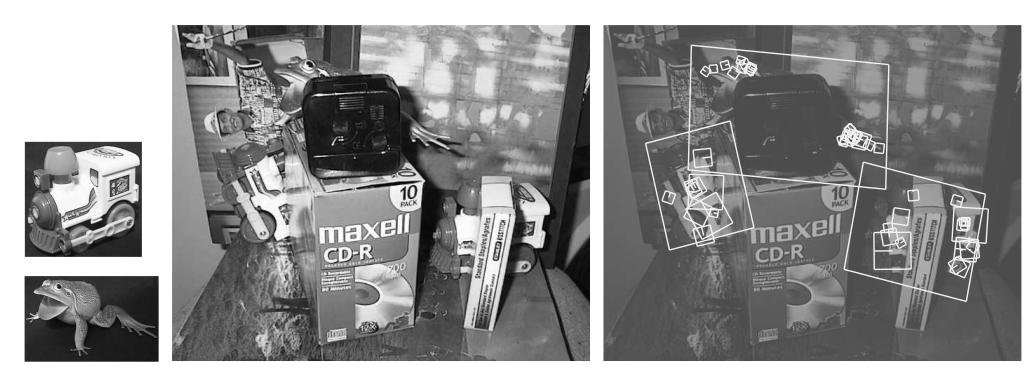

In [9]:
from IPython.display import Image 
Image("object_rec.png")

#### CNN -

In traditional fully connected neural networks, the structural information present in the images is lost as we flatten the image at the start. CNN tries to remedy this problem by introducing the convolution process[4]. We basically convolve the source image with a filter (called kernel) to extract structural information from the image. For example - vertical edges could be extracted from the images if we are interested in finding poles in the image. The game changer in CNN however is the fact that it learns the values of the filters in the training stage. We can also use multiple filters to extract different type of information and can also apply the convolution layer to output of another layer. 

   To use CNN's for object detection, it is converted into a classification problem [6]. This approach is different than what SIFT uses. In CNN, different sized windows are used to get part of the image and then try to classify that subimage in one of the categories. If the image contains an object which the CNN was trained on then it will classify it. However, as we can intuitively guess, it is very time and resource consuming to convolve the image with that many windows and then classify the large number of images resulting from the convolution. Mask R-CNN tries to solve this problem


   Mask R-CNN [5]- It is built on the foundations of R-CNN and Fast R-CNN. In R-CNN, instead of feeding all the image patches to CNN. It narrows down the number to around 2000 pathes by using a algorithm called Selective Search. It only selects regions where it thinks an object might be present. Fast R-CNN speeds the training even more by using a algorithm called Spatial Pyramid Pooling and also by parallelizing the process of bounding box regression with classification. Mask R-CNN extends Fast R-CNN by genrating pixel level masks in addition to bounding boxes which increases accuracy [7]


# Methods -


## 1. Resources - 


### 1.1 Dataset - 

I used the Kangaroo dataset [9] for training and testing, which contains 183 annotated images of Kangaroos. Each image has single or multiple Kangaroos. Some of the images also have other animals present in them. The photos are taken in the field and at different angles and illumination. Therefore, making it a good choice to test the Mask R-CNN and SIFT method. Each image also has an accompanying XML file which has image dimensions and bounding box co-ordinates for Kangaroos in each image. 


### 1.2 Code -

I used code from multiple on-line sources and made modifications to customize it for this project's use and also to solve compatibility issues. Code sources can be found at the top of code cells.

### 1.3 Compute - 

I used Google Colab [10] and CS department machines to run the experiments.



## Evaluation method - 

I trained the Mask R-CNN model on the subset of images from Kangaroo dataset and calculated mean absolute precision on training and testing sets. For SIFT, the goal was to use the same evaluation approach. However, that did not go that well as explained later in the report

I also displayed some of the images with Mask R-CNN bounding box predictions and did some qualitative evalution




# Implementation and Results

## SIFT implementation for example - 



#### pythonSIFT[8] implementation of SIFT

Time taken - 123.2590548992157 seconds.


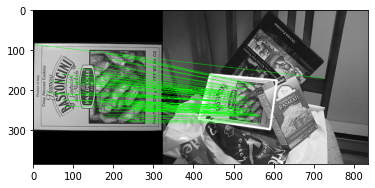

In [26]:
'code credit - https://github.com/rmislam/PythonSIFT'


import numpy as np
import cv2
import pysift
import matplotlib
from matplotlib import pyplot as plt
import logging
logger = logging.getLogger(__name__)

dpi = matplotlib.rcParams['figure.dpi']

MIN_MATCH_COUNT = 10

start_time = time.time()

#Read images
img1 = cv2.imread('box.png', 0)           # queryImage
img2 = cv2.imread('box_in_scene.png', 0)  # trainImage

# Compute SIFT keypoints and descriptors
kp1, des1 = pysift.computeKeypointsAndDescriptors(img1)
kp2, des2 = pysift.computeKeypointsAndDescriptors(img2)

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

if len(good) > MIN_MATCH_COUNT:
    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, (255, 68, 51), 3, cv2.LINE_AA)

    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2

    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (0, 255, 0))
        
    print(f'Time taken - {(time.time() - start_time)} seconds.')
    
    

    imshow(newimg)

 ## SIFT implementation

### I implemented SIFT using Python-SIFT and OpenCV

 #### SIFT with different object image and target image

In [124]:
'code credit - https://github.com/rmislam/PythonSIFT'


import numpy as np
import cv2
import pysift
import matplotlib
from matplotlib import pyplot as plt
import logging
import time
from matplotlib.pyplot import imshow



logger = logging.getLogger(__name__)

#dpi = matplotlib.rcParams['figure.dpi']

MIN_MATCH_COUNT = 10

start_time = time.time()


img_list = []


#img1 = cv2.imread('kang_crop/kang_image_29.png', 0)           # queryImage
#kp1, des1 = pysift.computeKeypointsAndDescriptors(img1)

for image in range(18,31):
    
    #Read images
    
    filepath = 'kang_crop/kang_image_' + str(image) + '.jpg'

    img_list.append(cv2.imread(filepath,  cv2.IMREAD_COLOR))
    
    
    
keypoint_list = []
desc_list = []

#imshow(img_list[1])

cntr = 0

'''
for img in img_list:
    
    cntr += 1
    try:
        kp, des = pysift.computeKeypointsAndDescriptors(img)
    except:
        print(cntr)
        
    
    keypoint_list.append(kp)
    desc_list.append(des)
    
'''
i1 = cv2.imread('00132.png', cv2.IMREAD_COLOR)
i2 = cv2.imread('kangaroo/images/00143.jpg', cv2.IMREAD_COLOR)

#imshow(i1)

img1 = cv2.cvtColor(i1 , cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(i2,   cv2.COLOR_BGR2GRAY)
#img2 = cv2.imread('00003.jpg',0)
#i3 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    

# Compute SIFT keypoints and descriptors
kp1, des1 = pysift.computeKeypointsAndDescriptors(img1)
kp2, des2 = pysift.computeKeypointsAndDescriptors(img2)

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
        
print(f'Number of matching keypoints - {len(good)}')

if len(good) > MIN_MATCH_COUNT:
    

    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, (255, 68, 51), 3, cv2.LINE_AA)

    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2

    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (0, 255, 0))
        
    print(f'Time taken - {(time.time() - start_time)} seconds.')
    
    
    imshow(newimg)



Number of matching keypoints - 1


 ### SIFT with same object and target image

Number of matching keypoints - 884
Time taken - 559.8537094593048 seconds.


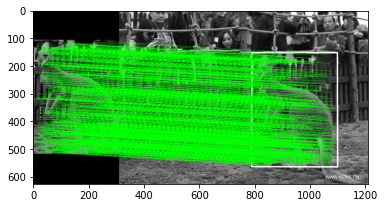

In [126]:
import numpy as np
import cv2
import pysift
import matplotlib
from matplotlib import pyplot as plt
import logging
import time
from matplotlib.pyplot import imshow



logger = logging.getLogger(__name__)

#dpi = matplotlib.rcParams['figure.dpi']

MIN_MATCH_COUNT = 10

start_time = time.time()


img_list = []


#img1 = cv2.imread('kang_crop/kang_image_29.png', 0)           # queryImage
#kp1, des1 = pysift.computeKeypointsAndDescriptors(img1)

for image in range(18,31):
    
    #Read images
    
    filepath = 'kang_crop/kang_image_' + str(image) + '.jpg'

    img_list.append(cv2.imread(filepath,  cv2.IMREAD_COLOR))
    
    
    
keypoint_list = []
desc_list = []

#imshow(img_list[1])

cntr = 0

'''
for img in img_list:
    
    cntr += 1
    try:
        kp, des = pysift.computeKeypointsAndDescriptors(img)
    except:
        print(cntr)
        
    
    keypoint_list.append(kp)
    desc_list.append(des)
    
'''
i1 = cv2.imread('00132.png', cv2.IMREAD_COLOR)
i2 = cv2.imread('kangaroo/images/00132.jpg', cv2.IMREAD_COLOR)

#imshow(i1)

img1 = cv2.cvtColor(i1 , cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(i2,   cv2.COLOR_BGR2GRAY)
#img2 = cv2.imread('00003.jpg',0)
#i3 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    

# Compute SIFT keypoints and descriptors
kp1, des1 = pysift.computeKeypointsAndDescriptors(img1)
kp2, des2 = pysift.computeKeypointsAndDescriptors(img2)

# Initialize and use FLANN
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Lowe's ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
        
print(f'Number of matching keypoints - {len(good)}')

if len(good) > MIN_MATCH_COUNT:
    

    # Estimate homography between template and scene
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]

    # Draw detected template in scene image
    h, w = img1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)

    img2 = cv2.polylines(img2, [np.int32(dst)], True, (255, 68, 51), 3, cv2.LINE_AA)

    h1, w1 = img1.shape
    h2, w2 = img2.shape
    nWidth = w1 + w2
    nHeight = max(h1, h2)
    hdif = int((h2 - h1) / 2)
    newimg = np.zeros((nHeight, nWidth, 3), np.uint8)

    for i in range(3):
        newimg[hdif:hdif + h1, :w1, i] = img1
        newimg[:h2, w1:w1 + w2, i] = img2

    # Draw SIFT keypoint matches
    for m in good:
        pt1 = (int(kp1[m.queryIdx].pt[0]), int(kp1[m.queryIdx].pt[1] + hdif))
        pt2 = (int(kp2[m.trainIdx].pt[0] + w1), int(kp2[m.trainIdx].pt[1]))
        cv2.line(newimg, pt1, pt2, (0, 255, 0))
        
    print(f'Time taken - {(time.time() - start_time)} seconds.')
    
    
    imshow(newimg)






## Mask R-CNN implementaiton [11]



In [115]:
!ls

00003.jpg			   kangaroo_cfg20210514T1812
11tGkk6hdwELkH66Vng2x-b2xCmmsv0bc  kangaroo_cfg20210514T1835
assets				   kangaroo_eval.ipynb
build				   kang_crop
dist				   LICENSE
images				   MANIFEST.in
kangaroo			   mask_rcnn_coco.h5
kangaroo_cfg20210512T1621	   mask_rcnn.egg-info
kangaroo_cfg20210512T1630	   mask_rcnn_kangaroo_cfg_0004.h5
kangaroo_cfg20210512T1820	   mrcnn
kangaroo_cfg20210512T1831	   __pycache__
kangaroo_cfg20210512T1937	   pysift.py
kangaroo_cfg20210512T1952	   README.md
kangaroo_cfg20210512T2009	   requirements.txt
kangaroo_cfg20210512T2016	   samples
kangaroo_cfg20210512T2047	   setup.cfg
kangaroo_cfg20210512T2212	   setup.py
kangaroo_cfg20210513T0200	   test_rcnn.py


## 1.1 Define class to load images and extract co-ordinates of bounding boxes

 ### In the following code cell -
     - Load all the libraries (Implementing Mask R-CNN requires installing third party library which can be found here - )
     - def load_dataset() loads images from the specified directory. Image-00090 throws error therefore skipping it
     - def extract_boxes() extracts the bounding box co-ordinates from the xml file for each image
     - def load_masks() converts bounding boxes to masks so that they can be used by the Mask R-CNN library

In [35]:
%cd Mask_RCNN

/s/chopin/k/grad/anfanger/courses/cs445/final_project/Mask_RCNN


In [2]:
'code credit - https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/'

# detect kangaroos in photos with mask rcnn model
from os import listdir
from xml.etree import ElementTree

from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean

from matplotlib import pyplot
from matplotlib.patches import Rectangle

from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.model import mold_image
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap

 


# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# load all bounding boxes for an image
	def extract_boxes(self, filename):
		# load and parse the file
		root = ElementTree.parse(filename)
		boxes = list()
		# extract each bounding box
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

    # load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']



## 1.2 Load train and test datasets using the class defined above 

Using 80/20 split for training and testing

In [3]:
# load the train dataset
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the test dataset
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


Train: 131
Test: 32


 ## 1.3 Showing some of the images to add some clarity

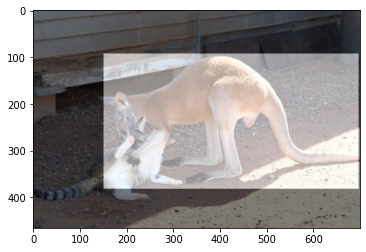

In [6]:
image_id = 0
image = train_set.load_image(image_id)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

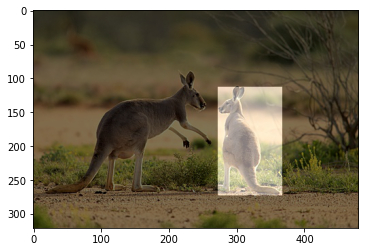

In [19]:
image_id = 1
image = train_set.load_image(image_id)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

 ## 1.4 Displaying image with bounding boxes and class labels for better understanding

### Explaination -

    display_instances() is a function provided by mask-rcnn library which displays images with labels and bounding boxes

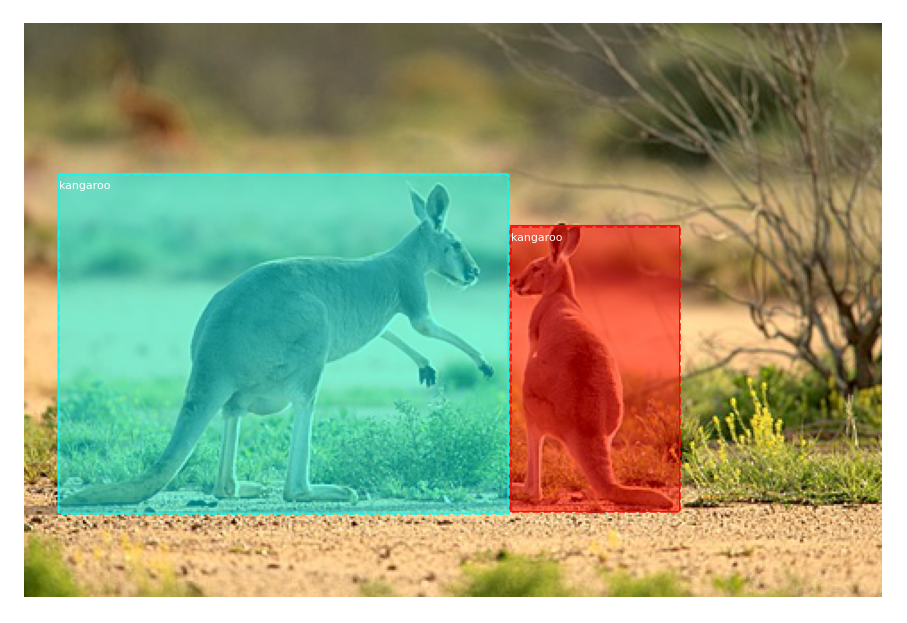

In [20]:
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

 # 2. Training 

### 2.1 Defining function to change some parameters

### Explaination - 
    KangarooConfig() class extends the default mrcnn class to change some parameters. For example - I have reduced the STEPS_PER_EPOCH to save time

In [21]:
class KangarooConfig(Config):
  # define the name of the configuration
  NAME = "kangaroo_cfg"
  # number of classes (background + kangaroo)
  #BATCH_SIZE = 16
  NUM_CLASSES = 1 + 1
  # number of training steps per epoch
  STEPS_PER_EPOCH = 11; 
  #BATCH_SIZE = 16

In [22]:
config = KangarooConfig()

### 2.2 Defining the model and starting training

### Explaination - 
    - The initial weights are are loaded from a predefined model `mask_rcnn_coco.h5`
    - Note :- Training gets stuck on CS machines therefore I completed it on Google Colab. Including the code here for completeness (the output is incomplete)

In [36]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20210514T1835/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistri

KeyboardInterrupt: 

# 3. Evaluation

     Note - I completed training on Google Colab and downloaded the trained model for evaluation

### Explaination -
    PredictionConfig() class is similar to KangarooConfig(), just changes some additional parameters not previously changed

In [37]:
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

In [40]:
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id )
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

#### Loading the model in inference mode instead of training mode for evaluation
    

In [41]:
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('mask_rcnn_kangaroo_cfg_0004.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

/usr/local/python-env/py36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Train mAP: 0.873
Test mAP: 0.920


   #### Plotting images with annotated bounding boxes vs predicted for visual evaluation and analysis

In [78]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=1, start=0):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i+start)
        mask, _ = dataset.load_mask(i+start)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        pyplot.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        pyplot.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    pyplot.tight_layout()
    pyplot.show()




 Training Image Number - 1


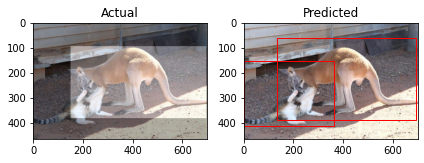

In [134]:
# plot predictions for train dataset
print('\n\n Training Image Number - 1')
plot_actual_vs_predicted(train_set, model, cfg, start=0)



 Training Image Number - 2


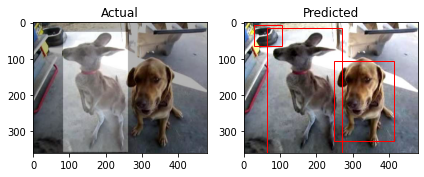

In [135]:
print('\n\n Training Image Number - 2')
plot_actual_vs_predicted(train_set, model, cfg, start=10)



 Training Image Number - 3


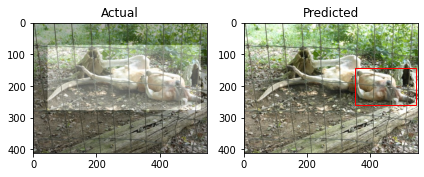

In [136]:
print('\n\n Training Image Number - 3')
plot_actual_vs_predicted(train_set, model, cfg, start=5)

## Images from testing set



 Testing Image Number - 1


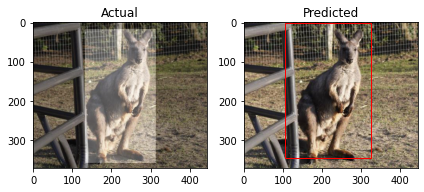

In [137]:
# plot predictions for test dataset
print('\n\n Testing Image Number - 1')
plot_actual_vs_predicted(test_set, model, cfg, start=0)



 Testing Image Number - 2


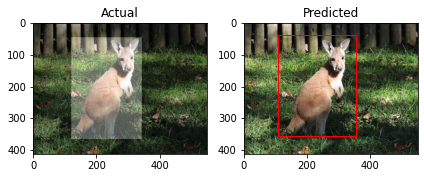

In [138]:
print('\n\n Testing Image Number - 2')
plot_actual_vs_predicted(test_set, model, cfg, start=20)



 Testing Image Number - 3


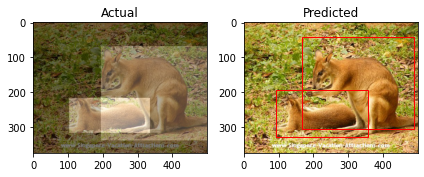

In [139]:
print('\n\n Testing Image Number - 3')
plot_actual_vs_predicted(test_set, model, cfg, start=6)

 # Discussion -
 
 - Tasks performed 
     - Perform object detection using SIFT
     - Perform object detection using Mask R-CNN
   
 - SIFT
     - I wanted to do a head on comaprison of SIFT and Mask R-CNN but SIFT performed very poorly (as can be seen in the implementation section) on all the images. It was not able to go above the minimum required matching points to detect an object
     - It was only able to meet the threshold when the object was from the target image which is not usefull at all
     - Therefore, a direct comparison was not possible. However, 1. It is an lesson to someone doing the same thing in the future (I will post this on github) and 2. it would be interesting to investigate the reasons for this failure by applying SIFT to a different dataset
     - I have seen various papers where the authors have successfully used SIFT for object detection. Therefore, it can be concluded that I made some errors in implementation or the dataset might not be suitable
 
 
 - Mask R-CNN 
 
     - mAP :- mean absolute precision
     - Precision value
         - Train mAP: 0.873
         - Test mAP: 0.920
      
     - The results I got were fairly good considering the fact that I trained it for small number of epochs (5) and also reduced the steps per epoch to speed up the training process
     - Testing mAP is more than training mAP. That is counterintuitive. It might be due to very small size of testing set (~30 images)
     - Computational power was a major bottleneck in performing extensive testing ( It took approximately 6-7 hours for training to complete on Google Colab (Free version) with just 5 epochs)
     - As can be seen from the result images, it performs better if only single bounding box is present. 
     - There are significant number of false positives if more than one kangaroos are present in the images
     - NN based approaches are much more versatile. For example - A NN model trained on pictures of Kangaroos learns the notion of a Kangaroo and is able to detect any Kangaroo. 
     - Mask R-CNN was significantly more computationaly demanding and time consuming than SIFT
     

 
     

 # Conclusion -
 
I implemented object detection using SIFT using Python-SIFT and Mask R-CNN using the mask r-cnn library. The aim was to make a versus comparison of them, however, SIFT performed very poorly rendering the comparison useless. I successfully implemenented Mask R-CNN and got ~90% testing accuracy on the test set. The trained model performed fairly well on images which had only single object (kangaroo) but had false positives if there were more than one objects.
    In future, it would be interesting to investigate reasons for SIFT's failure and perform extensive testing of the Mask R-CNN based approach by changing dataset, parameters (epochs, learning rate), etc.
 
 
 
#### What I learned - 
     - How SIFT works behind the scenes - the concept of scale space, difference of gaussian, feature descriptor, etc. 
     - How SIFT is implemented in Python
     - Various applications of SIFT - Image stitching, object detection, image matching
     - Failure and success scenarios while using SIFT
     - How NN based approaches are used in object detection
     - How object detection problem is converted into a classification problem so that NNs can be used on it
     - How R-CNN works -How it uses selective search to narrow down the regions in an image to increase efficiency
     - How Mask R-CNN works - How it uses the concept of pixel level masks to increase accuracy (even though I did not use it in the project)
     - Prilimilary understanding of Mask R-CNN python library and various API calls that can be made to it
     

 # References -
 
 [1] SuperPoint: Self-Supervised Interest Point Detection and Description, Daniel DeTone, Tomasz Malisiewicz, Andrew Rabinovich
 
 [2] https://en.wikipedia.org/wiki/Digital_image_processing
 
 [3] David G. Lowe, "Distinctive image features from scale-invariant keypoints," International Journal of Computer Vision, 60, 2 (2004), pp. 91-110.
 
 [4] https://machinelearningmastery.com/crash-course-convolutional-neural-networks/
 
 [5] Kaiming He and Georgia Gkioxari and Piotr Dollár and Ross Girshick, "Mask R-CNN"
 
 [6] https://cv-tricks.com/object-detection/faster-r-cnn-yolo-ssd/
 
 [7] https://alittlepain833.medium.com/simple-understanding-of-mask-rcnn-134b5b330e95#:~:text=Mask%20RCNN%20is%20a%20deep,two%20stages%20of%20Mask%20RCNN.
 
 [8] https://github.com/rmislam/PythonSIFT
 
 [9] https://github.com/experiencor/kangaroo
 
 [10] https://colab.research.google.com/
 
 [11] https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

In [140]:
import io
from nbformat import current
import glob
nbfile = glob.glob('../Project_Report.ipynb')
if len(nbfile) > 1:
    print('More than one ipynb file. Using the first one.  nbfile=', nbfile)
with io.open(nbfile[0], 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')
word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print('Word count for file', nbfile[0], 'is', word_count)

Word count for file ../Project_Report.ipynb is 2148
